## Imports and basic definitions

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")
sns.set_style("ticks")

import matplotlib.pyplot as plt

import mne
mne.set_log_level(False)
from os import listdir

mfile = '/home/jona/experiments/delphi/delphi_p6/standard.elp'

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

sourceloc = "../for_mne/"
fnames = [sourceloc + x for x in listdir(sourceloc) if ".set" in x]

## Get data objects

In [2]:
event_id = {"control":100, "syntax":200}

def get_raw(fname, lowpass=.1, highpass=20):
    raw = mne.io.read_raw_eeglab(
        fname, event_id=event_id, preload=True, verbose=False, montage=mfile).filter(
        lowpass, highpass, n_jobs='cuda', filter_length='auto',
        l_trans_bandwidth='auto', h_trans_bandwidth='auto')
    mne.io.set_eeg_reference(raw, ["FT10", "FT9"], copy=False)
    return raw

def get_epochs(fname, lowpass=.1, highpass=20, tmin=-.5, tmax=1.5, fix_isi=True):
    raw = get_raw(fname, lowpass, highpass)
    events = mne.find_events(raw)
    if fix_isi:
        events[:, 0] += 30
    return mne.Epochs(raw, events, event_id, tmin, tmax)

def get_evokeds(fname, lowpass=.1, highpass=20, tmin=-.5, tmax=1.5):
    epochs = get_epochs(fname, lowpass, highpass, tmin, tmax)
    return {cond:epochs[cond].average() for cond in event_id}

## Get Evokeds

In [3]:
evokeds = [get_evokeds(fname) for fname in fnames]
evoked = evokeds[0]["control"]
mapping = {"syntax":"Syntactic\nViolation", "control":"Control\nTrial"}
mapping = {"syntax":"Syntactic Violation", "control":"Control Trial"}

evokeds_dict = {name:[subj[cond] for subj in evokeds] for cond, name in mapping.items()}

## Helper to determine IAF

In [4]:
picks = "P1, Pz, P2, PO3, POz, PO4, O2, Oz, O2".lower().split(", ")

from philistine.mne import savgol_iaf

def get_piaf(fname):
    raw = get_raw(fname)
    picks_ = [ii for ii, elec in enumerate(raw.ch_names) if elec.lower() in picks]
    piaf, cog, ablimits = savgol_iaf(raw, picks=picks_, fmin=7, fmax=14, ax=False)
#    print(piaf)
    return np.array([#piaf - 2,
                     piaf -1, piaf, piaf + 1,
                     #piaf + 2
    ])

## Get TFR for one subject

In [5]:
from mne.time_frequency import tfr_morlet
import numpy as np

conds = "syntax", "control"

lfreq=2
hfreq=25
freqs = np.arange(lfreq, hfreq, .25)
def get_tfr(fname, lfreq=2, hfreq=25, freqs=freqs):
    print(".", end="")
    if freqs == "piaf":
        freqs = get_piaf(fname)
    epochs = get_epochs(fname, lowpass=None, highpass=None, tmin=-4., tmax=5.5)
    return [tfr_morlet(epochs[cond], freqs, [int(x / 3) + 3 for x in freqs],
                       use_fft=False, return_itc=False, decim=1, n_jobs=6,
                       picks=None, zero_mean=True, average=True, verbose=None).crop(-.5, 1.5)
            for cond in conds]

In [6]:
#lower_alpha = list(freqs).index(8)
#upper_alpha = list(freqs).index(15)


## Calculate TFR

In [7]:
tfrs_orig = [get_tfr(fname, freqs=freqs) for fname in fnames]

..................

In [8]:
tfrs = [get_tfr(fname, freqs="piaf") for fname in fnames]

......................

In [9]:
ga_orig = mne.grand_average([(syntax - control) for syntax, control in tfrs_orig])
ga = mne.grand_average([(syntax - control) for syntax, control in tfrs])
ga3 = ga.copy().crop(-.5, 1.5)
d = ga3.data[:, :, :].mean(1)

In [10]:
evs_tf = [mne.EvokedArray((syntax - control).data[:,
                                                  :#lower_alpha:upper_alpha,
                                                  ,:].mean(1),  # redo with 8-14; 
                       ga3.info, tmin=ga3.times[0]) for syntax, control in tfrs]  # separately do for upper and lower alpha

In [11]:
tfr_ev = mne.EvokedArray(d, ga3.info, tmin=ga3.times[0])

## Main plot 1

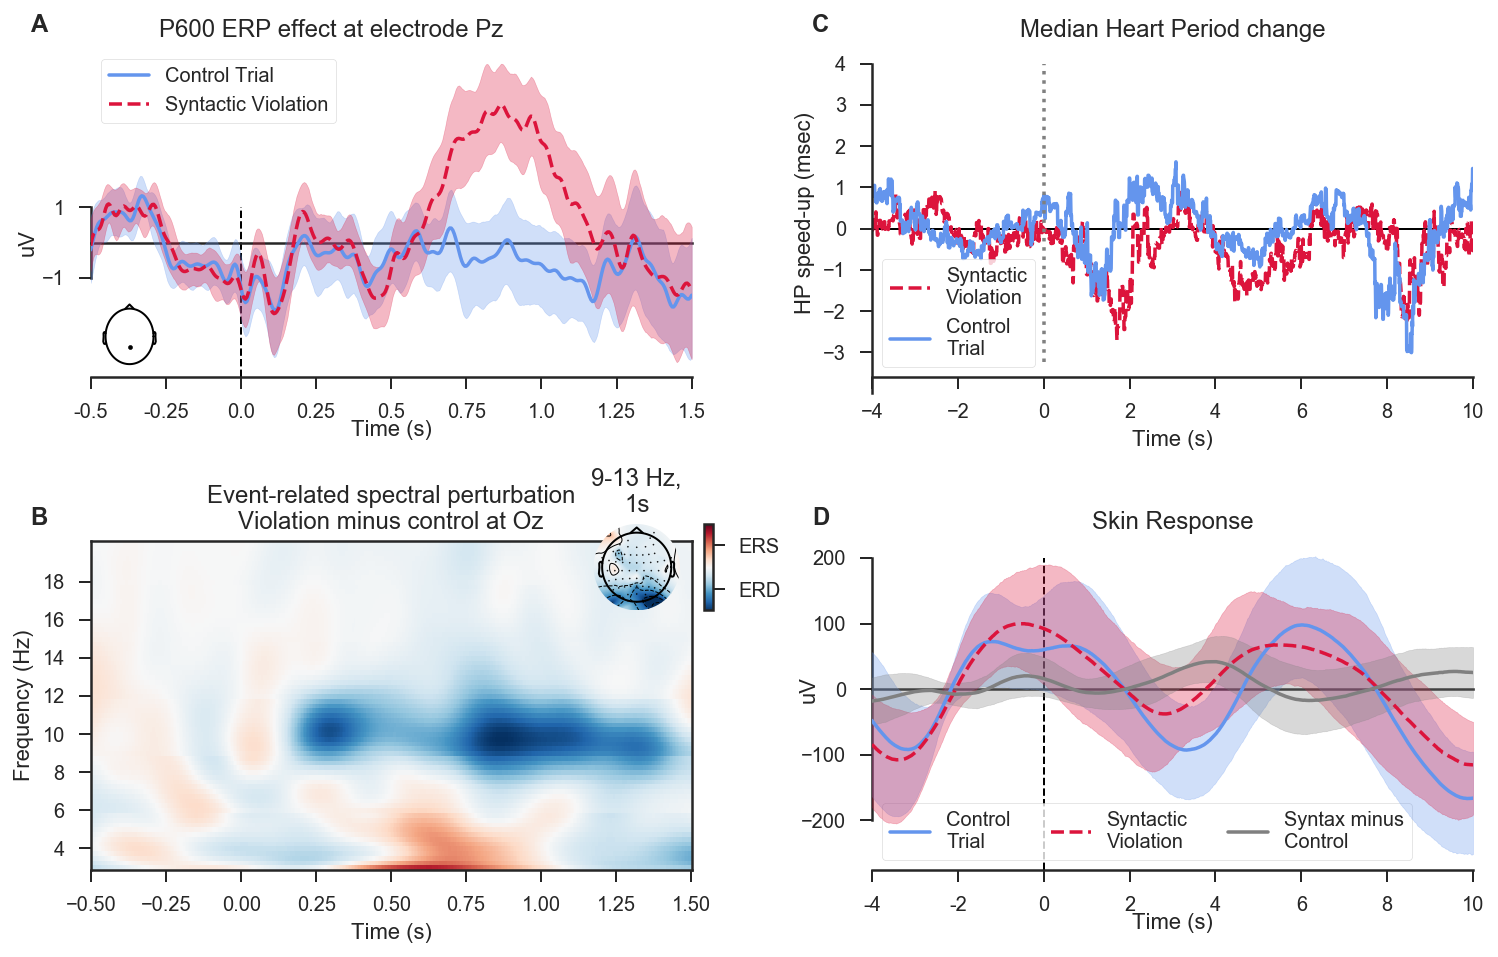

In [12]:
f = plt.figure()
f.set_size_inches((12, 6))


axes = plt.subplot(2, 2, 1)
inset = plt.axes([0.775, 0.8, .15, .15])
f.subplots_adjust(hspace=.33)

colors = {"Syntactic Violation":"Crimson", "Control Trial":"CornFlowerBlue"}
linestyles = {"Syntactic Violation":"--", "Control Trial":"-"}

mne.viz.plot_compare_evokeds(
    evokeds_dict, picks=evoked.ch_names.index("Pz"),
    colors=colors, linestyles=linestyles, truncate_yaxis=True,
    axes=axes, show=False, show_sensors=3,#vlines=[0, 1.]
                            );
axes.set_title("P600 ERP effect at electrode Pz", x=.4, y=1.)
axes.text(-.1, 1.05, "A", transform=axes.transAxes, weight="bold", fontsize=12)
axes.legend(loc="upper left", frameon=True)

mne.combine_evoked((mne.grand_average(evokeds_dict["Control Trial"]),
                    mne.grand_average(evokeds_dict["Syntactic Violation"])),
                   (-.5, .5)).plot_topomap(
    1., outlines='skirt', contours=8, axes=inset, show=False, colorbar=False);
inset.set_title("1 s")

axes2 = plt.subplot(2, 2, 3)
inset2 = plt.axes([0.366, 0.3, .1, .1])
inset2.set_title("1 s")

ch = evoked.ch_names.index("Oz")

ga2 = ga_orig.copy().crop(-.5, 1.5)
ga2.apply_baseline(baseline=(None, 0), mode="mean")
ga2.plot([ch], axes=axes2, show=False, colorbar=False,
        tmin=-.5, tmax=1.5, fmin=3, fmax=20,
            );

tfr_ev.plot_topomap([1.], outlines="skirt", average=.25, colorbar=False, title='', #size=5,
                       time_format="", axes=inset2, show=False);
inset2.set_title("9-13 Hz,\n1s"#, loc='left'
                )
inset3 = plt.axes([0.455, 0.3, .005, .1])
cbar = plt.colorbar(inset2.images[0], ax=inset2, cax=inset3)
cbar.set_ticks((-0.0001, 0.0001))
cbar.set_ticklabels(("ERD", "ERS"))

axes2.set_title("Event-related spectral perturbation\nViolation minus control at Oz")
axes2.set_yticks((4, 6, 8, 10, 12, 14, 16, 18))

axes2.text(-.1, 1.05, "B", transform=axes2.transAxes, weight="bold", fontsize=12)

colors = {"Syntactic\nViolation":"Crimson", "Control\nTrial":"CornFlowerBlue"}
linestyles = {"Syntactic\nViolation":"--", "Control\nTrial":"-"}
evokeds_pulse = {cond:mne.read_evokeds(sourceloc + "evokeds_pulse_{}-ave.fif".format(cond)) for cond in colors}
times = evokeds_pulse["Syntactic\nViolation"][0].times

both = {event: np.median([ev.data[1, :] for ev in value], 0)
        for event, value in evokeds_pulse.items()}

ax = plt.subplot(222)
for cond, vals in both.items():
    ax.plot(times,
            vals * 1e6, label=cond,
            color=colors[cond], linestyle=linestyles[cond])

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_bounds(-4, 4)
ax.spines['bottom'].set_smart_bounds(True)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.plot((0, 0), (ax.get_ylim()[0], 4), linestyle=":", color="grey")
ax.axhline(0, color="k", zorder=-1, linewidth=1)

ax.set_xlim(*times[[0, -1]])

ax.legend(loc="lower left", frameon=True)
ax.set_ylabel("HP speed-up (msec)")
ax.set_xlabel("Time (s)")
ax.set_title("Median Heart Period change")

ax.text(-.1, 1.05, "C", transform=ax.transAxes, weight="bold", fontsize=12)

ax = plt.subplot(224)

colors = {"Syntactic\nViolation":"Crimson", "Control\nTrial":"CornFlowerBlue",
          "Syntax minus\nControl": "grey"}
linestyles = {"Syntactic\nViolation":"--", "Control\nTrial":"-", "Syntax minus\nControl": "-"}
evokeds_skin = {cond:mne.read_evokeds(sourceloc + "evokeds_skin_{}-ave.fif".format(cond)) for cond in colors}

mne.viz.plot_compare_evokeds({ev: [ev_.copy()
                                   for ev_ in vals]
                              for ev, vals in evokeds_skin.items()},
                             picks=0, show_sensors=False,
                             colors=colors,
                             linestyles=linestyles,
                             title="Skin Response",
                             ci=.95,
                             axes=ax,
                             truncate_yaxis="max_ticks", show=False);
ax.legend(loc=3, ncol=3, frameon=True)
ax.set_xticklabels([-6, -4, -2, 0, 2, 4, 6, 8, 10]);
ax.text(-.1, 1.05, "D", transform=ax.transAxes, weight="bold", fontsize=12)
f.subplots_adjust(hspace=.5, wspace=.3)

#f.savefig(sourceloc + "allplot.pdf", bbox_inches="tight")

## Function for 2nd main plot

In [13]:
from matplotlib.lines import Line2D

from mne.channels.layout import _find_topomap_coords
pos_xy = np.asarray(_find_topomap_coords(evoked.info, range(len(evoked.ch_names))))
pos_x, pos_y = pos_xy.T

def check_1020_hemisphere(name):
    """Decide if a 10-20 channel is on the left,
    right or midline, based on its name"""
    n = name[-1].lower()
    if n in {"z", '1', '2'}:
        return 'midline'
    else:
        return "left" if bool(int(n) % 2) else "right"


def do_one_hemi(evoked, pos_y, p_vals, ax, position, indices, vmin, vmax, tmin, tmax, image_alpha,
                alpha, alphas, do_contours, label_contours, unit, col=0, last_row=False):
    if col == 0:
        s = "{}\n\n{}\n".format(("Channels\n< back <       > front >"
                                 if position == "midline" else ""), position)
        ax.set_ylabel(s)
    picks = pos_y[indices].argsort()
    data = evoked.data[indices][picks] * unit

    p_vals_ = p_vals[indices][picks]
    ax.vlines(0, 0, len(picks), linestyle=":", color="grey")
    im_args = dict(extent=(tmin, tmax, 0, len(data)), aspect="auto", cmap="RdBu_r",
                   interpolation='nearest', origin="lower", vmin=vmin, vmax=vmax)
    im = ax.imshow(data, alpha=image_alpha, **im_args)

    ax.imshow(np.ma.masked_where(p_vals_ >= alpha, data), alpha=1, **im_args)
#    if col == 0:
    ax.set_yticks(np.arange(len(picks)) + .5)
    ax.set_yticklabels(np.array(evoked.ch_names)[indices][picks])
#    else:
#        ax.set_yticks([])

    ls = list()
    if do_contours:
        for ii, this_alpha in enumerate(alphas):#[alpha]
            cs = ax.contour(p_vals_, antialiase=True, levels=[this_alpha], linestyle="--",
                            origin="lower", cmap='Greys_r', alpha=1-(1 - (ii / len(alphas))) * .666,
                            extent=(tmin, tmax, -.5, len(data)+.5), #label='p < ' + str(alpha)
                           )
            ls.append(Line2D((0, 0), (0, 0), color="k", label='p < ' + str(alpha),
                             #c=(1 - (ii / len(alphas)))) * .9
                             alpha=1-(1 - (ii / len(alphas)))*.666)
                     )
            if label_contours:
                ax.clabel(cs, fontsize=13, fmt={this_alpha:'p < ' + str(this_alpha)},
                          levels=[this_alpha], inline_spacing=-1, antialiased=True)
    if last_row:
        ax.set_xlabel("Time (s)")
#    else:
#        ax.set_xticklabels([])
    return ls, im


def plot_image_hemi(evoked, p_vals, alpha=.05, alphas=[.05], do_contours=True, unit=1e6,
                    size=(8, 18), title='', colorbar="uV", label_contours=False, image_alpha=.33,
                    axes=None, ncols=1, col=0):
    "pvals=2D (channels, times), alpha: image mask, alphas=contours"
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    from mne.channels.layout import _find_topomap_coords
    pos_xy = np.asarray(_find_topomap_coords(evoked.info, range(len(evoked.ch_names))))
    pos_x, pos_y = pos_xy.T

    hemi = np.asarray([check_1020_hemisphere(ch) for ch in evoked.ch_names])
    positions = sorted(list(set(hemi)))
    if axes is None:
        f, axes = plt.subplots(len(positions), ncols, #sharex=True
                              )
        f.set_size_inches(size)
    else:
        f = axes.flatten()[0].figure
    if ncols > 1:
        axes = axes[:, col]

    tmin, *_, tmax = evoked.times
    vmax = np.abs(evoked.data).max() * unit
    vmin = -vmax
    for jj, (ax, position) in enumerate(zip(axes, positions)):
        indices = [hemi == position]
        ls, im = do_one_hemi(evoked, pos_y, p_vals, ax, position, indices, vmin, vmax, tmin, tmax,
                             image_alpha, alpha, alphas, do_contours, label_contours, unit, col=col,
                             last_row=jj == len(positions) - 1)

    if col != 0:
        ax.legend(ls, ['p < ' + str(alpha) for alpha in alphas],
              loc='upper right', bbox_to_anchor=(1., 3.75))

    if colorbar:
        f.colorbar(im, ax=axes[:3].ravel().tolist(), fraction=.1, aspect=40, pad=.07,
                   label=colorbar, orientation="horizontal")
#    f.suptitle(title, y=.925)
    axes[0].set_title(title)
    axes[0].text(-.0, 3.5, "ABCDEF"[col], transform=ax.transAxes, weight="bold", fontsize=12)

    return f

# 2D cluster test on time-frequency data

In [14]:
template = tfr_ev.copy()
conn, ch_names = mne.channels.find_ch_connectivity(template.info, 'eeg')
from functools import partial
sigma = 1e-6
stat_fun = partial(mne.stats.ttest_1samp_no_p, sigma=sigma)

In [15]:
X_tf = np.array([ev.data.T for ev in evs_tf])

from scipy import stats
threshold = -stats.distributions.t.ppf(0.05, len(X_tf) - 1)
tfce = dict(start=0, step=0.2)

t_obs, clusters, cluster_pv_tf, H0 = res = mne.stats.spatio_temporal_cluster_1samp_test(
    X_tf, tfce, connectivity=conn, out_type="mask", n_jobs=6, stat_fun=stat_fun, n_permutations=1024 * 1)

Provided stat_fun does not treat variables independently. Setting buffer_size to None.


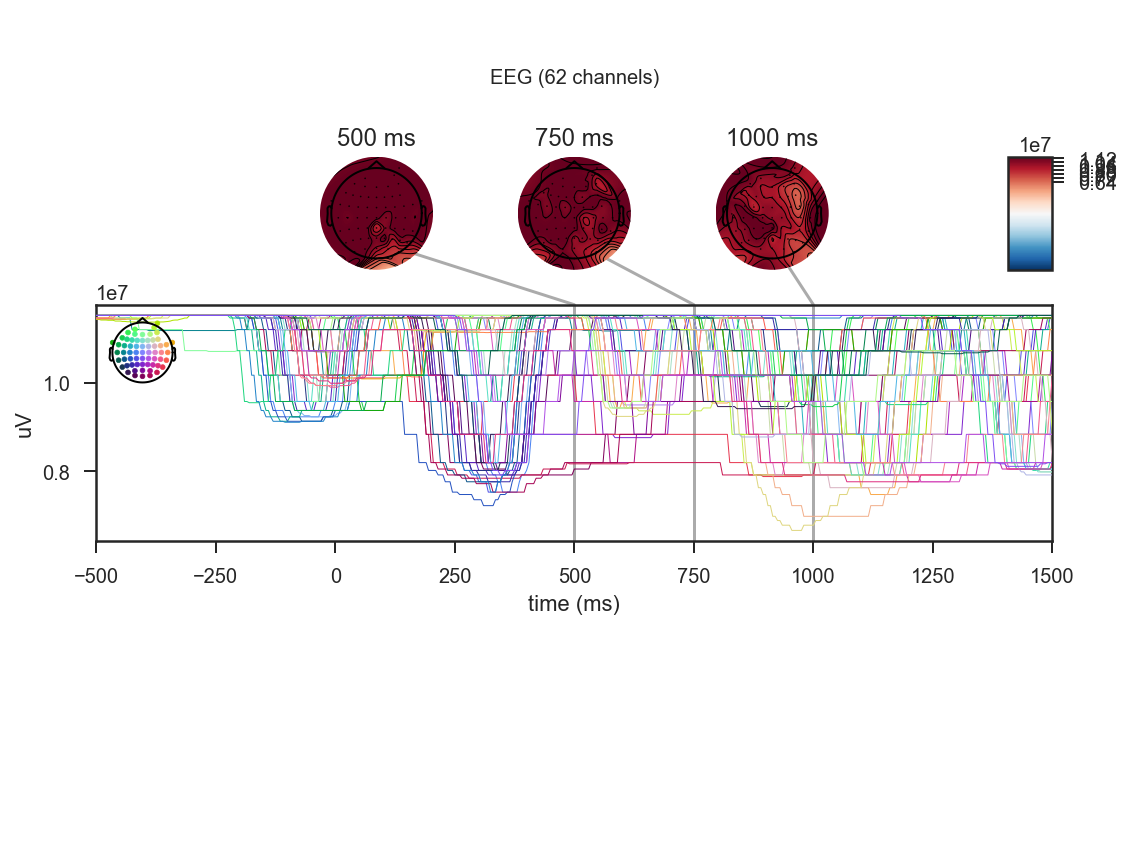

In [16]:
ga4 = tfr_ev.copy()
ga4.data = np.log1p((cluster_pv_tf.reshape(t_obs.shape)) * 100000).T
ga4.plot_joint(times=[.5, .75, 1.]);

# 2D cluster test on evoked data

In [17]:
conn, ch_names = mne.channels.find_ch_connectivity(template.info, 'eeg')

from functools import partial
sigma = 1e-3
stat_fun = partial(mne.stats.ttest_1samp_no_p, sigma=sigma)

X_erp = np.array([syntax.data.T - control.data.T for (syntax, control) in
              zip(*list((evokeds_dict['Syntactic Violation'],
                         evokeds_dict['Control Trial'])))])

from scipy import stats
threshold = -stats.distributions.t.ppf(0.01, len(X_erp) - 1)
tfce = dict(start=0, step=0.2)

t_obs, clusters, cluster_pv_erp, H0 = res = mne.stats.spatio_temporal_cluster_1samp_test(
    X_erp, tfce, connectivity=conn, out_type="mask", n_jobs=6, stat_fun=stat_fun,
    n_permutations=1024 * 1)

Provided stat_fun does not treat variables independently. Setting buffer_size to None.


In [18]:
evoked_erp = mne.combine_evoked((mne.grand_average(evokeds_dict["Control Trial"]),
                    mne.grand_average(evokeds_dict["Syntactic Violation"])),
                   (-.5, .5))

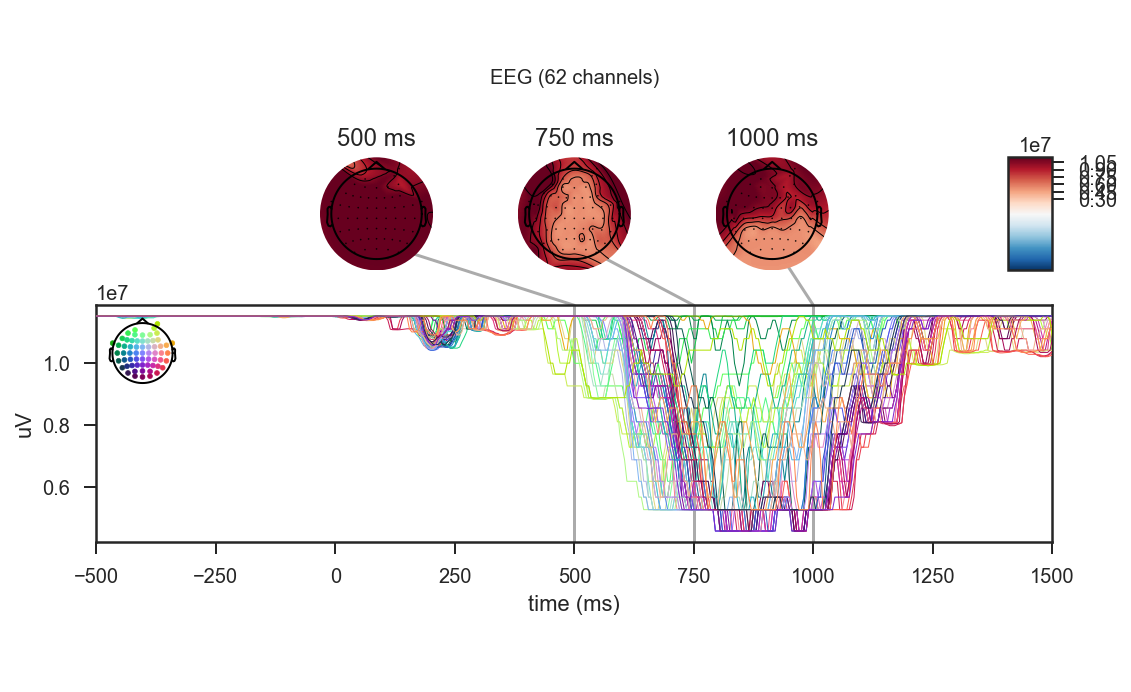

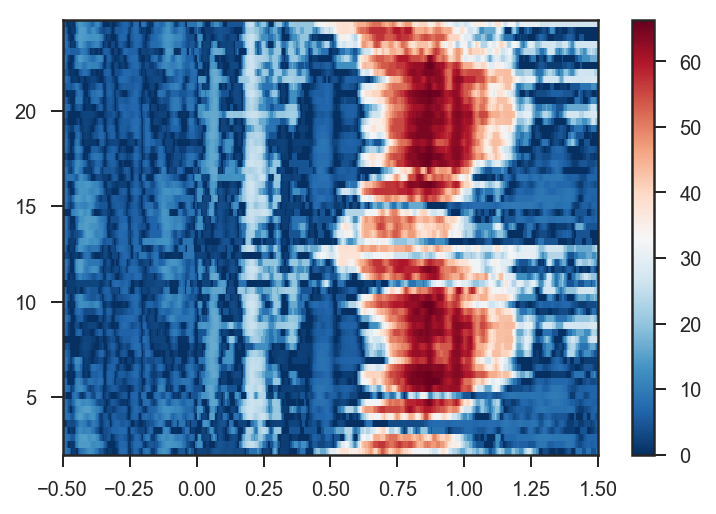

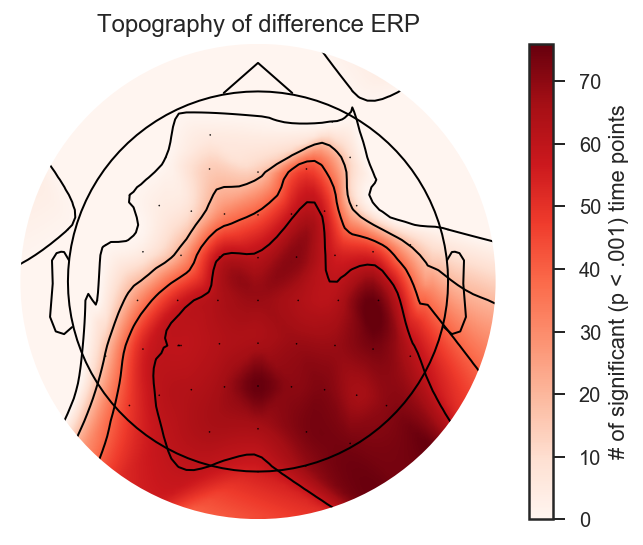

In [19]:
#for clus in np.where(cluster_pv < .05)[0]:
#    ga4 = tfr_ev.copy()
#    ga4.data = clusters[clus].T.astype(float)
#    ga4.data = (t_obs.T * 100000) ** 2
#    ga4.plot_joint(times=[.5, .75, 1.]);

ga4 = tfr_ev.copy()
#ga4.data = clusters[clus].T.astype(float)
#ga4.data = (t_obs.T * 100000) ** 2
ga4.data = np.log1p((cluster_pv_erp.reshape(t_obs.shape)) * 100000).T
ga4.plot_joint(times=[.5, .75, 1.]);

#clusters[clus].T.shape

f = plt.figure()
im = plt.imshow(t_obs.T, aspect="auto", cmap="RdBu_r", origin="lower",
          extent=(ga4.times.min(), ga4.times.max(), freqs[0], freqs[-1]))
plt.colorbar(im)

f = plt.figure()
im, cn = mne.viz.plot_topomap((cluster_pv_erp < .01).reshape(t_obs.shape).T.sum(1), tfr_ev.info, outlines="skirt", show=False)
plt.gca().set_title("Topography of difference ERP")
plt.colorbar(im, label="# of significant (p < .001) time points")

## Main plot 2, masked for significance

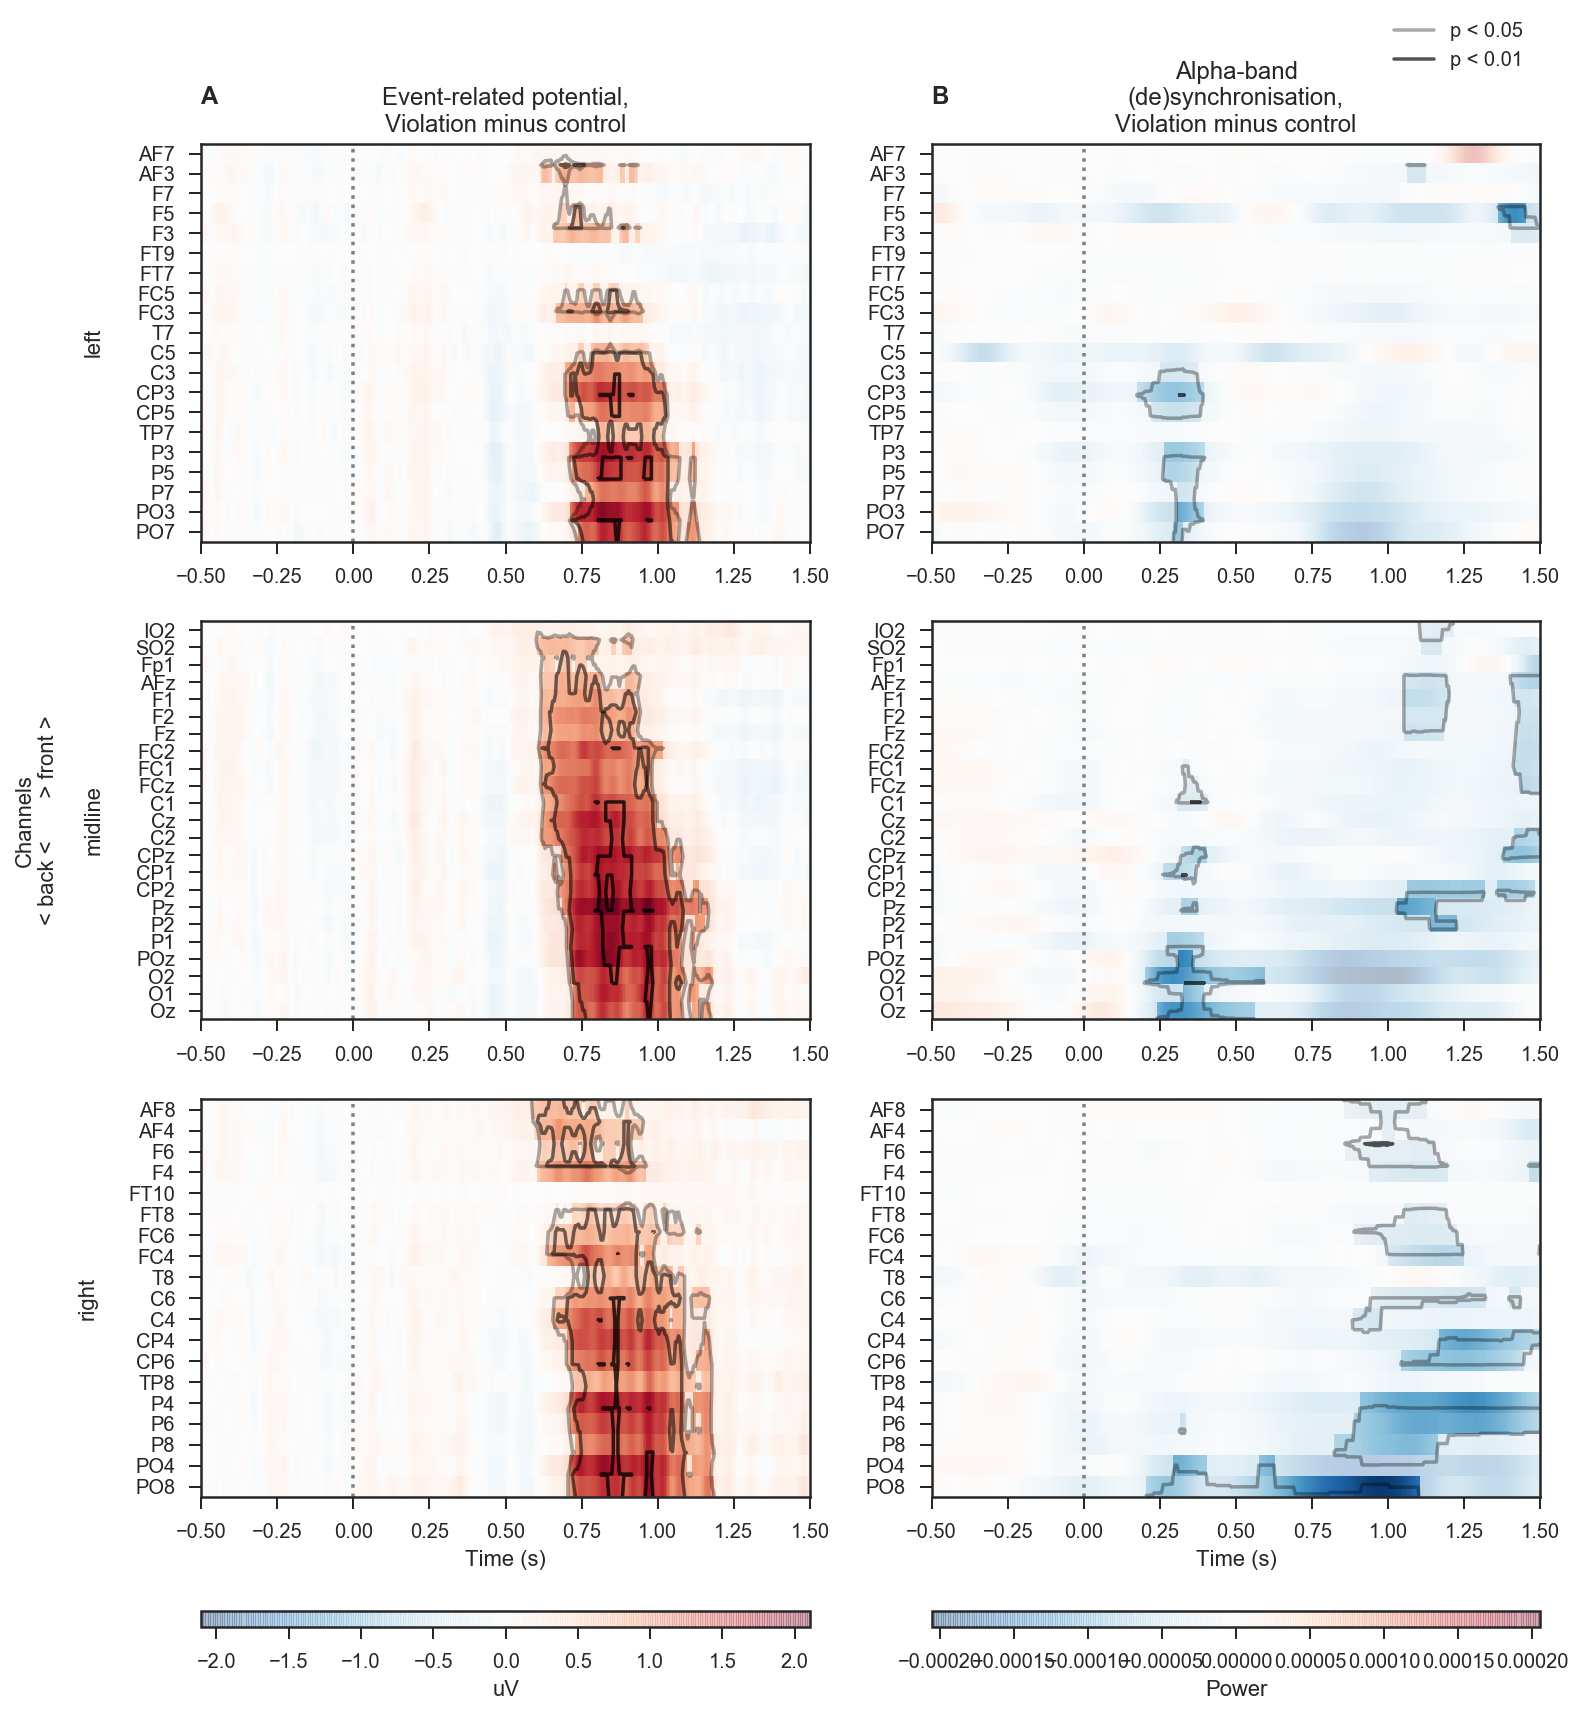

In [20]:
f, axes = plt.subplots(3, 2)
f.set_size_inches((12, 15))

plot_image_hemi(evoked_erp, cluster_pv_erp.reshape(t_obs.shape).T, alphas=[ .05, .01, .001
                                                                          ],
                title="Event-related potential,\nViolation minus control",
                ncols=2, col=0, axes=axes);

plot_image_hemi(tfr_ev, cluster_pv_tf.reshape(t_obs.shape).T, alphas=[.05, .01
                                                                     ],
                title="Alpha-band\n(de)synchronisation,\nViolation minus control",
                ncols=2, col=1, axes=axes, colorbar="Power");
#f.savefig(sourceloc + "/combiplot_2.pdf", bbox_inches='tight')